<a href="https://colab.research.google.com/github/Deepshikhar/High_Precision_Aerial_Image_Segmentation/blob/main/High_Precision_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Define utility functions

In [2]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        plt.show()


    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        plt.show()

import albumentations as A

def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

In [17]:
CSV_FILE = '/content/drive/MyDrive/Road_seg_dataset/train.csv'
DATA_DIR = '/content/drive/MyDrive/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 50
LR = 0.001
BATCH_SIZE = 32
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

## Load the dataset

In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


## Visualize the image and mask data samples

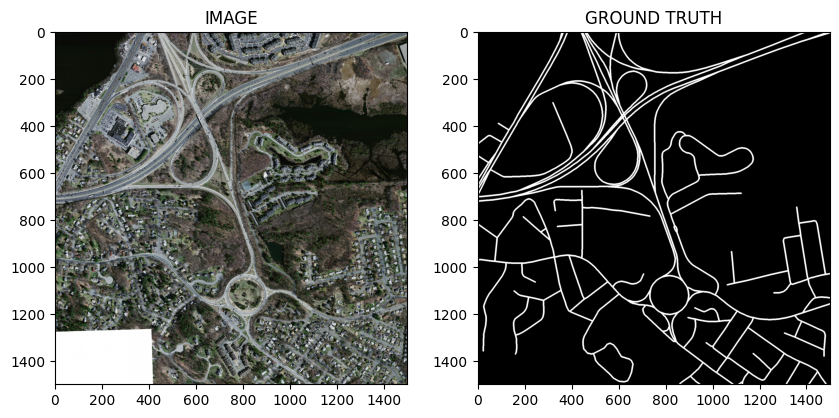

In [5]:
idx = 2

row =df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

## Splitting that dataset into train and test

In [6]:
train_df, valid_df = train_test_split(df,test_size = 0.2,random_state=42)
len(train_df),len(valid_df)

(159, 40)

## Creating Custome dataset

In [7]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row =self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # (h,w,c)
    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w)

    mask = np.expand_dims(mask,axis=-1) #(h,w,c)

    if self.augmentations:
      data = self.augmentations(image = image,mask = mask)
      image = data['image'] #(h,w,c)
      mask = data['mask']


    image = np.transpose(image,(2,0,1)).astype(np.float32) #(c,h,w)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32) #(c,h,w)

    image = torch.Tensor(image) /255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image,mask

In [8]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

## Loading the dataset into batches

In [9]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


## Installing the required modules

In [10]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-us3rkf7e
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-us3rkf7e
  Resolved https://github.com/albumentations-team/albumentations to commit 3c510e1422f6663ccd5026950af2d9ea85b5302a
  Preparing metadata (setup.py) ... done


## Creating custom model using U-net as a backbone

In [11]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self,images,masks=None):

      logits = self.backbone(images)

      if masks!=None:
        return logits, DiceLoss(mode='binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits,masks)

      return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

In [13]:
def train_fn(dataloader,model,optimizer):

  model.train() # Turn ON dropout,batchnorm, etc ..

  total_loss = 0.0

  for images,masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [14]:
def eval_fn(dataloader,model):

  model.eval() # Turn ON dropout,batchnorm, etc ..

  total_loss = 0.0

  with torch.no_grad():
      for images,masks in tqdm(dataloader):

        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        logits,loss = model(images,masks)
        total_loss += loss.item()

      return total_loss / len(dataloader)

## Train our Model

In [19]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [20]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model,optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(),"best-model.pt")
    print('SAVED-MODEL')
    best_loss = valid_loss

  print(f'Epoch: {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}')

100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


SAVED-MODEL
Epoch: 1 Train Loss : 0.9672858148813248 Valid Loss : 0.9381187558174133


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


SAVED-MODEL
Epoch: 2 Train Loss : 0.8012835770845413 Valid Loss : 0.7975560307502747


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


SAVED-MODEL
Epoch: 3 Train Loss : 0.7312887966632843 Valid Loss : 0.7453916192054748


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Epoch: 4 Train Loss : 0.6974229425191879 Valid Loss : 0.7674808621406555


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


SAVED-MODEL
Epoch: 5 Train Loss : 0.6865225464105607 Valid Loss : 0.7000521779060364


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


SAVED-MODEL
Epoch: 6 Train Loss : 0.661957523226738 Valid Loss : 0.6830551862716675


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


SAVED-MODEL
Epoch: 7 Train Loss : 0.6499667048454285 Valid Loss : 0.6772332549095154


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch: 8 Train Loss : 0.6430097699165345 Valid Loss : 0.6950717210769654


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch: 9 Train Loss : 0.6295073837041855 Valid Loss : 0.727094542980194


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


SAVED-MODEL
Epoch: 10 Train Loss : 0.6205967545509339 Valid Loss : 0.6764500498771667


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


SAVED-MODEL
Epoch: 11 Train Loss : 0.6133629024028778 Valid Loss : 0.6519177675247192


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


SAVED-MODEL
Epoch: 12 Train Loss : 0.6073156654834747 Valid Loss : 0.6510305881500245


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch: 13 Train Loss : 0.6160821735858917 Valid Loss : 0.6589646100997925


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Epoch: 14 Train Loss : 0.6023541375994682 Valid Loss : 0.6895708918571473


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVED-MODEL
Epoch: 15 Train Loss : 0.5928086370229722 Valid Loss : 0.6497901439666748


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVED-MODEL
Epoch: 16 Train Loss : 0.5885418623685836 Valid Loss : 0.6462167382240296


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


SAVED-MODEL
Epoch: 17 Train Loss : 0.5982434034347535 Valid Loss : 0.6409835100173951


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch: 18 Train Loss : 0.5931281864643096 Valid Loss : 0.6441943883895874


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


SAVED-MODEL
Epoch: 19 Train Loss : 0.5757422432303428 Valid Loss : 0.6352861046791076


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


SAVED-MODEL
Epoch: 20 Train Loss : 0.5769789308309555 Valid Loss : 0.6198307514190674


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch: 21 Train Loss : 0.5728843986988068 Valid Loss : 0.6420215606689453


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch: 22 Train Loss : 0.5657859340310096 Valid Loss : 0.6521020889282226


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch: 23 Train Loss : 0.5715572863817215 Valid Loss : 0.6352020978927613


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch: 24 Train Loss : 0.561965161561966 Valid Loss : 0.6417564034461976


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


SAVED-MODEL
Epoch: 25 Train Loss : 0.5609214514493942 Valid Loss : 0.6160196185111999


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch: 26 Train Loss : 0.5590537250041961 Valid Loss : 0.6158517837524414


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 27 Train Loss : 0.5599743261933326 Valid Loss : 0.6261120438575745


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 28 Train Loss : 0.5649792000651359 Valid Loss : 0.6612048983573914


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch: 29 Train Loss : 0.5606591269373894 Valid Loss : 0.655739688873291


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 30 Train Loss : 0.5554859772324562 Valid Loss : 0.6514024496078491


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch: 31 Train Loss : 0.5527914941310883 Valid Loss : 0.6268626689910889


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch: 32 Train Loss : 0.5403403148055077 Valid Loss : 0.632335364818573


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 33 Train Loss : 0.5399878591299057 Valid Loss : 0.6226479291915894


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 34 Train Loss : 0.5444077387452125 Valid Loss : 0.6419378042221069


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 35 Train Loss : 0.5488200187683105 Valid Loss : 0.6364114284515381


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch: 36 Train Loss : 0.5309600621461869 Valid Loss : 0.6083991050720214


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch: 37 Train Loss : 0.5379827693104744 Valid Loss : 0.6250962138175964


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


Epoch: 38 Train Loss : 0.5290131911635398 Valid Loss : 0.6210600018501282


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch: 39 Train Loss : 0.5313796758651733 Valid Loss : 0.6364154100418091


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 40 Train Loss : 0.5282544702291488 Valid Loss : 0.619478988647461


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 41 Train Loss : 0.5282812133431435 Valid Loss : 0.649615204334259


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 42 Train Loss : 0.5247545346617699 Valid Loss : 0.6358132243156434


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 43 Train Loss : 0.5207599997520447 Valid Loss : 0.632081139087677


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch: 44 Train Loss : 0.5186090245842934 Valid Loss : 0.6159679055213928


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch: 45 Train Loss : 0.5193928703665733 Valid Loss : 0.6233432173728943


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


SAVED-MODEL
Epoch: 46 Train Loss : 0.5153970748186112 Valid Loss : 0.5970000267028809


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Epoch: 47 Train Loss : 0.5111684426665306 Valid Loss : 0.6071079134941101


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 48 Train Loss : 0.5115908741950989 Valid Loss : 0.647171676158905


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch: 49 Train Loss : 0.5067524239420891 Valid Loss : 0.6090047955513


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

Epoch: 50 Train Loss : 0.5181216731667518 Valid Loss : 0.6054607510566712


## Testing our Segmentation Model

In [21]:
idx = 9

model.load_state_dict(torch.load('best-model.pt'))
image,mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c,h,w) -> (b,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

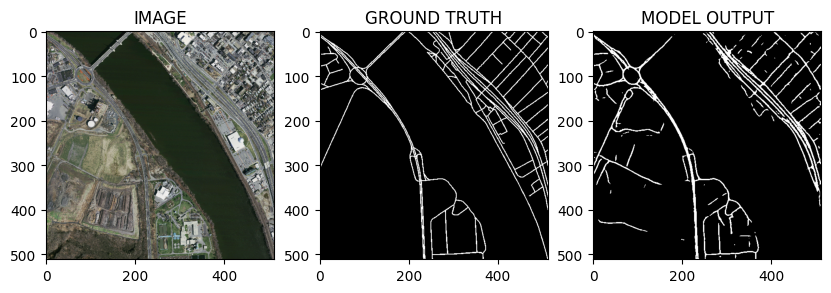

In [22]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))